In [1]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib

# To import h and normalize the mass
import pyTNG.cosmology as _cosmo
h = _cosmo.TNGcosmo.h

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [3]:
def update_df(df, h=_cosmo.TNGcosmo.h):
    df['StarMass', 0.0]= df['HaloMass']*df['FractionStars']/h*1e10
    df['HaloMass', 0.0]= df['HaloMass']/h*1e10
    return

In [4]:
def get_scatter(df, halo_prop='StarMass', bins=30, mode='median', threshhold=1e-3, y_axis='f_esc'):
    
    x_values = df.loc[:,(halo_prop,0.0)]
    edges = np.logspace(np.log10(x_values.min()),np.log10(x_values.max()), bins)
    
    means = {}
    quantile16 = {}
    quantile84 = {}
    error = {}
    centers = []
    variance = {}
    
    for key in df[y_axis].keys():
        means[key]=[]
        quantile16[key]=[]
        quantile84[key]=[]
        error[key]=[]
        variance[key]=[]
    
    for i in range(len(edges)-1):
        centers.append(np.exp((np.log(edges[i+1])+np.log(edges[i]))/2.))
        for key in df[y_axis].keys():
            sub_fesc = df[(edges[i]*(1-1e-10)<df[halo_prop, 0.0]) & (df[halo_prop, 0.0]<edges[i+1])][y_axis, key]
        
            if mode == 'median':
                means[key].append(sub_fesc.median())
            elif mode == 'mean':
                means[key].append(sub_fesc.mean())
            quantile16[key].append(sub_fesc.quantile(0.16))
            quantile84[key].append(sub_fesc.quantile(0.84))
            error[key].append(sub_fesc.std()/np.sqrt(sub_fesc.shape[0]))
            variance[key].append(sub_fesc.var())
        
    centers = np.array(centers)
    for key in df[y_axis].keys():
        means[key] = np.array(means[key])
        quantile16[key] = np.array(quantile16[key])
        quantile84[key]= np.array(quantile84[key])
        error[key] = np.array(error[key]) 
        variance[key] = np.array(variance[key])
        
    return centers, means, quantile16, quantile84, error, variance

In [87]:
def plot_mass_dependence(df, halo_prop='StarMass', bins=30, mode='median', with_redshift=False, save=False, lin=False):
    
    linewidth = 8
    quantile_alpha = 0.3
    upper_y_threshold = 1.
    lower_y_threshold = 1e-3
    lower_y_threshold_lin = 0.
    size_label = 50
    x_tick_major_size = 16
    x_tick_major_width = 4
    x_tick_minor_size = 8
    x_tick_minor_width = 3
    legend_fontsize = 35
    legend_loc = 'upper right'
    fig_width = 20
    fig_height = 25
    axes_width = 3
    tick_labelsize = 35
    y_label = r'$\langle f_\mathrm{esc} \rangle $'
    if halo_prop == 'HaloMass':
        x_label = 'Halo Mass [$\log(M_{\mathrm{sun}})$]'
    elif halo_prop == 'StarMass':    
        x_label = 'Stellar Mass [$\log(M_{\mathrm{sun}})$]'
    else:
        raise ValueError("Only defined for the properties 'HaloMass' and 'StarMass'")
        
    if with_redshift:
        centers_z6, means_z6, quantile16_z6, quantile84_z6, error_z6, variance_z6 = get_scatter(df[df.z==6], halo_prop=halo_prop, 
                                                                                      bins=bins, mode=mode, y_axis='f_esc')
        centers_z8, means_z8, quantile16_z8, quantile84_z8, error_z8, variance_z8 = get_scatter(df[df.z==8], halo_prop=halo_prop, 
                                                                                      bins=bins, mode=mode, y_axis='f_esc')
        centers_z10, means_z10, quantile16_z10, quantile84_z10, error_z10, variance_z10 = get_scatter(df[df.z==10], halo_prop=halo_prop, 
                                                                                      bins=bins, mode=mode, y_axis='f_esc')
        
    else
        centers, means, quantile16, quantile84, error, variance = get_scatter(df, halo_prop=halo_prop, 
                                                                                              bins=bins, mode=mode, y_axis='f_esc')
    
    f = plt.figure()
    plt.subplots_adjust(hspace=0.001)

    ax1 = plt.subplot2grid((1 ,1), (0,0))

    x_bins = np.log10(centers)
    for key in means.keys():
        ax1.plot(x_bins, means[key], linewidth=linewidth, label=f'$r={key}Rvir$')
    #ax1.fill_between(x_bins, quantile16, quantile84, color='red', alpha=quantile_alpha)
    if lin:
        #ax1.set_ylim(lower_y_threshold_lin, upper_y_threshold)
        pass
    else:
        ax1.set_yscale('log')
        ax1.set_ylim(lower_y_threshold, upper_y_threshold)
    ax1.set_xlabel(x_label, size=size_label)
    ax1.set_ylabel(y_label, size=size_label)
    ax1.tick_params(length=x_tick_major_size, width=x_tick_major_width)
    ax1.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
    ax1.legend(fontsize=legend_fontsize, loc=legend_loc)

    #xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
    #plt.setp(xticklabels, visible=True)
    plt.rcParams["figure.figsize"] = (fig_width, fig_height)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=tick_labelsize) 
    plt.rc('ytick', labelsize=tick_labelsize) 
    if save:
        if lin:
            path = f'/u/ivkos/analysis/plots/{halo_prop}_fesc_lin.pdf'
        else:
            if galaxy:
                path = f'/u/ivkos/analysis/plots/{halo_prop}_fesc_galaxy.pdf'
            else:
                path = f'/u/ivkos/analysis/plots/{halo_prop}_fesc.pdf'
        plt.savefig(path, bbox_inches = 'tight')
    plt.show();
    return

In [30]:
def plot_radius_dependence(df, mode='mean', with_redshift=False, save=False, lin=False):
    
    linewidth = 8
    quantile_alpha = 0.3
    upper_y_threshold = 1.
    lower_y_threshold = 1e-3
    lower_y_threshold_lin = 0.
    size_label = 60
    x_tick_major_size = 16
    x_tick_major_width = 4
    x_tick_minor_size = 8
    x_tick_minor_width = 3
    legend_fontsize = 35
    legend_loc = 'upper right'
    fig_width = 20
    fig_height = 25
    axes_width = 3
    tick_labelsize = 35
    y_label = r'$\langle f_\mathrm{esc} \rangle $'
    x_label = 'r [$R_\mathrm{vir}$]'
    redshifts = [6,8,10]
    
    if with_redshift:
        radii = {}
        fesc = {}
        for redshift in redshifts:
            radii[redshift] = []
            fesc[redshift] = []
            for key in df['f_esc'].keys():
                radii[redshift].append(key)
                if mode=='median':
                    fesc[redshift].append(df[df['z',0.0]==redshift]['f_esc', key].median())
                else:
                    fesc[redshift].append(df[df['z',0.0]==redshift]['f_esc', key].mean())
        
    else:
        radii = []
        fesc = []
        for key in df['f_esc'].keys():
            radii.append(key)
            if mode=='median':
                fesc.append(df['f_esc', key].median())
            else:
                fesc.append(df['f_esc', key].mean())
    
    f = plt.figure()
    plt.subplots_adjust(hspace=0.001)

    ax1 = plt.subplot2grid((1 ,1), (0,0))

    if with_redshift:
        ax1.plot(radii[6], fesc[6], linewidth=linewidth, color='red')
        ax1.plot(radii[8], fesc[8], linewidth=linewidth, color='blue')
        ax1.plot(radii[10], fesc[10], linewidth=linewidth, color='green')
    else:
        ax1.plot(radii, fesc, linewidth=linewidth, color='red')
    #ax1.fill_between(x_bins, quantile16, quantile84, color='red', alpha=quantile_alpha)
    if lin:
        #ax1.set_ylim(lower_y_threshold_lin, upper_y_threshold)
        pass
    else:
        ax1.set_yscale('log')
       # ax1.set_ylim(lower_y_threshold, upper_y_threshold)
    ax1.set_xlabel(x_label, size=size_label)
    ax1.set_ylabel(y_label, size=size_label)
    ax1.tick_params(length=x_tick_major_size, width=x_tick_major_width)
    ax1.tick_params(length=x_tick_minor_size, width=x_tick_minor_width, which='minor')
    ax1.legend(fontsize=legend_fontsize, loc=legend_loc)

    #xticklabels = ax1.get_xticklabels() + ax2.get_xticklabels()
    #plt.setp(xticklabels, visible=True)
    plt.rcParams["figure.figsize"] = (fig_width, fig_height)
    plt.rc('axes', linewidth=axes_width)
    plt.rc('xtick', labelsize=tick_labelsize) 
    plt.rc('ytick', labelsize=tick_labelsize) 
    if save:
        if lin:
            path = f'/u/ivkos/analysis/plots/radius_dependence_lin.pdf'
        else:
            path = f'/u/ivkos/analysis/plots/radius_dependence_fesc.pdf'
        plt.savefig(path, bbox_inches = 'tight')
    plt.show();
    return

In [9]:
df = pd.read_pickle('dfs/large_radii.pickle')
update_df(df)

No handles with labels found to put in legend.


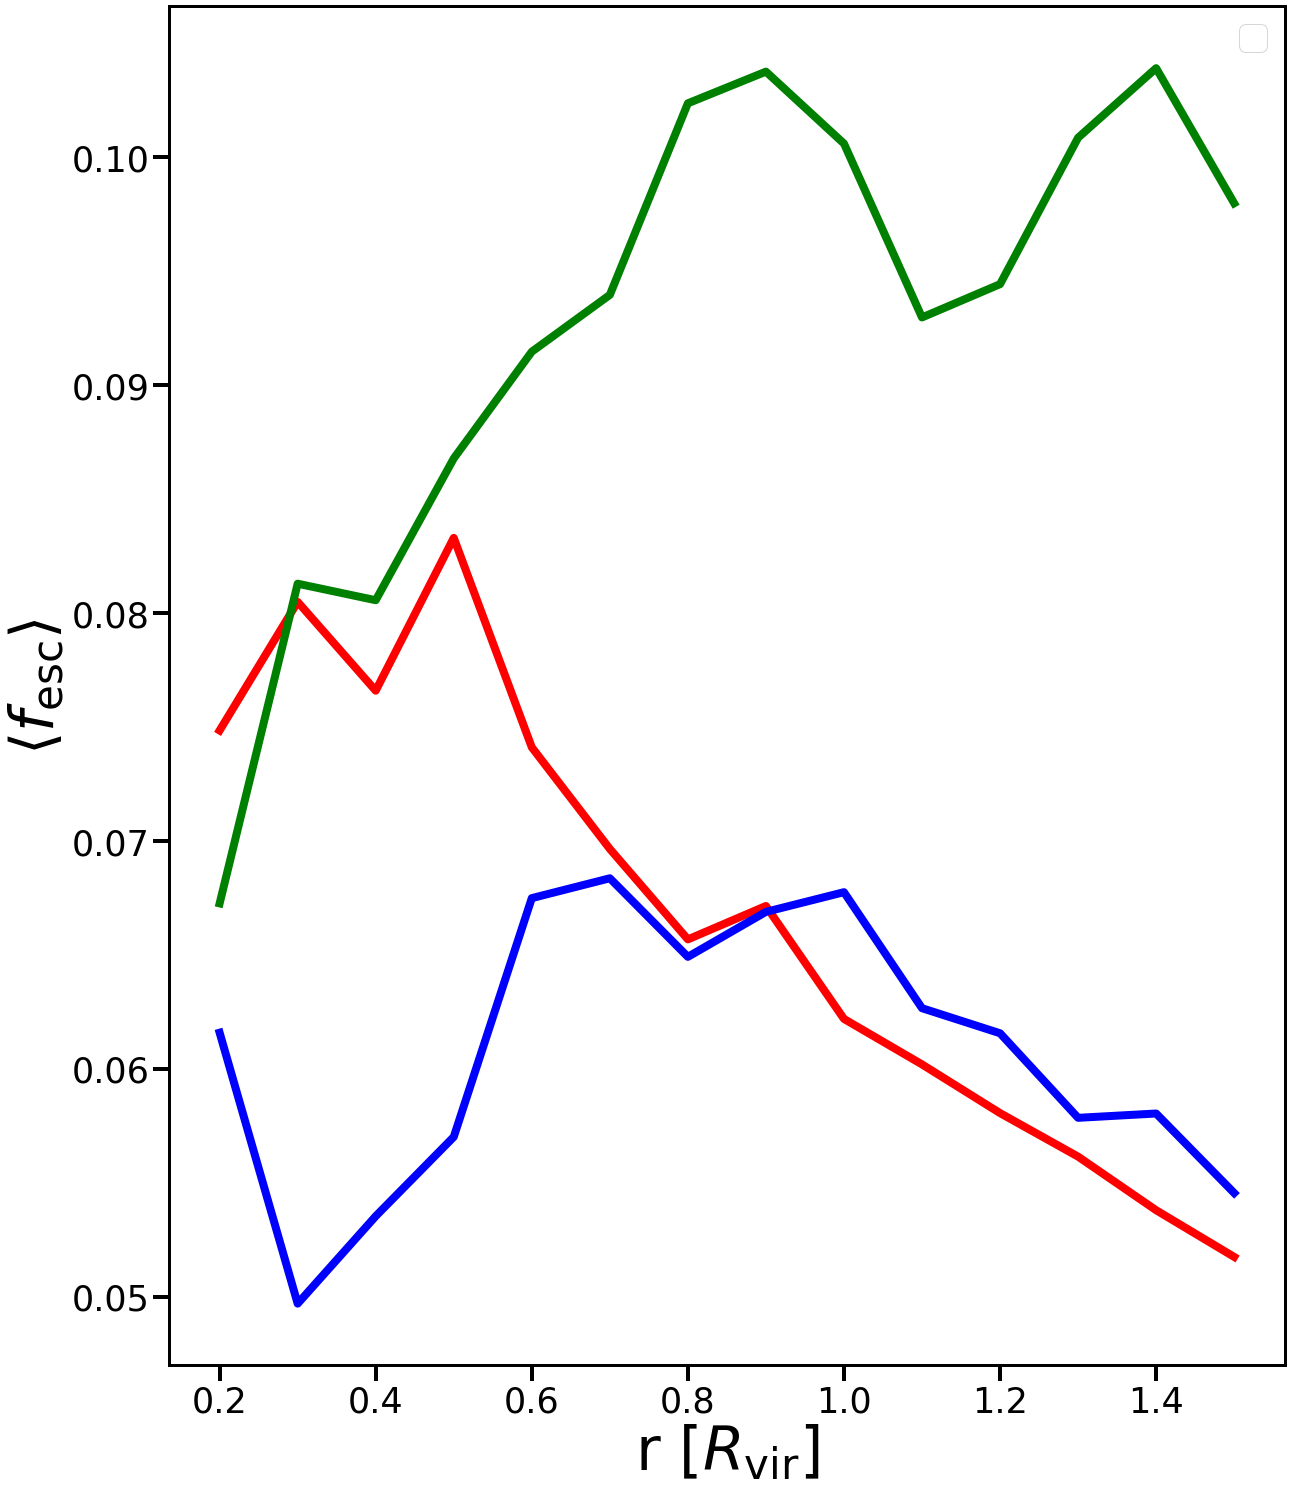

In [35]:
plot_radius_dependence(df, mode='mean', with_redshift=True, save=False, lin=True)

In [17]:
for key in df['f_esc']:
    print(key)

0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0
1.1
1.2
1.3
1.4
1.5


In [29]:
df['z',0.0]

0       6
1       6
2       6
3       6
4       6
       ..
222    10
223    10
224    10
225    10
226    10
Name: (z, 0.0), Length: 227, dtype: int64

In [23]:
test_df = df[df.z==6]

ValueError: cannot join with no overlapping index names

In [22]:
test_df['f_esc', 0.2].mean()

NameError: name 'test_df' is not defined

In [ ]:
fesc[redshift].append(df[df.z==redshift]['f_esc', key].mean())